In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import zipfile
import shutil

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Any results you write to the current directory are saved as output.

In [2]:
BASE_PATH = '../../data/raw/'
TRAINING_DIR = "../../data/raw/train_images/"
TESTING_DIR = "../../data/raw/test_images/"

print(os.listdir(BASE_PATH))

['.gitkeep', 'aptos2019-blindness-detection.zip', 'sample_submission.csv', 'test.csv', 'test_images', 'test_images.zip', 'train.csv', 'train_images', 'train_images.zip']


In [3]:
# Read the datasets for the model construction
train = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
submit = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

In [4]:
# Display the size of the train and test datasets.
print('The training dataset shape is : ',train.shape)
print('The testing dataset shape is  : ',test.shape)

The training dataset shape is :  (3662, 2)
The testing dataset shape is  :  (1928, 1)


In [5]:
# Display some basic information from the dataset.
print('Train dataset information:', '\n')
train.info()

Train dataset information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
id_code      3662 non-null object
diagnosis    3662 non-null int64
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [6]:
# Display the first 5 rows from the selected dataset.
print('Train dataset rows example:', '\n')
train.head()

Train dataset rows example: 



,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [7]:
# Display the first 5 rows from the selected dataset.
print('Train dataset rows example:', '\n')
test.head()

Train dataset rows example: 



,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


Image Id:: dfc7ec7db0e0 // Diagnosis :: 0


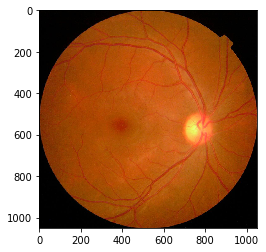

In [8]:
# Display one of the training set images. '002c21358ce6'.
BASE_PATH_TRAINING = os.path.join(BASE_PATH, 'train_images/')
id_code = list(train['id_code'].sample(1))
id_code = str(id_code[0])
img_path = BASE_PATH_TRAINING + id_code + ".png"

diagnosis = int(train[train.id_code == id_code].diagnosis)
print('Image Id:: {} // Diagnosis :: {}'.format(id_code, diagnosis))
img = mpimg.imread(img_path)
plt.imshow(img)
plt.show()

In [9]:
# Looking to the file structure for train and test folders.
train_dir = os.path.join(BASE_PATH, 'train_images')
train_dir_file_names = os.listdir(train_dir)
test_dir = os.path.join(BASE_PATH, 'test_images')
test_dir_file_names = os.listdir(test_dir)

print('Print image names: ', train_dir_file_names[:8])
print('Total train images:', len(os.listdir(train_dir)),'\n')
print('Print image names: ', test_dir_file_names[:8])
print('Total test images:', len(os.listdir(test_dir)))

Print image names:  ['000c1434d8d7.png', '001639a390f0.png', '0024cdab0c1e.png', '002c21358ce6.png', '005b95c28852.png', '0083ee8054ee.png', '0097f532ac9f.png', '00a8624548a9.png']
Total train images: 3662 

Print image names:  ['0005cfc8afb6.png', '003f0afdcd15.png', '006efc72b638.png', '00836aaacf06.png', '009245722fa4.png', '009c019a7309.png', '010d915e229a.png', '0111b949947e.png']
Total test images: 1928


In [10]:
# Naming the dataset base on clinician severity
# 0 - no_dr
# 1 - mild
# 2 - moderate
# 3 - severe
# 4 - proliferative_dr

def add_severity(df):
    '''Add a new columns to the dataset with the clinical severity '''
    conditions = [(df['diagnosis'] == 0),(df['diagnosis'] == 1),(df['diagnosis'] == 2),(df['diagnosis'] == 3),(df['diagnosis'] == 4)]
    choices = ['no_dr', 'mild', 'moderate', 'severe', 'proliferative_dr']
    df['severity'] = np.select(conditions, choices, default = 'other')
    return df

train = add_severity(train)
train.head()

,id_code,diagnosis,severity
0,000c1434d8d7,2,moderate
1,001639a390f0,4,proliferative_dr
2,0024cdab0c1e,1,mild
3,002c21358ce6,0,no_dr
4,005b95c28852,0,no_dr


In [11]:
for id_code, _, severity in train[:10].values:
    print(id_code, severity)

000c1434d8d7 moderate
001639a390f0 proliferative_dr
0024cdab0c1e mild
002c21358ce6 no_dr
005b95c28852 no_dr
0083ee8054ee proliferative_dr
0097f532ac9f no_dr
00a8624548a9 moderate
00b74780d31d moderate
00cb6555d108 mild


In [71]:
# Model Hyperparameters
BATCH_SIZE = 32
TEST_BATCH_SIZE = 1
EPOCHS = 10
VERBOSE = 1
HEIGHT = 128
WIDTH = 128
NUM_CLASSES = 5
LEARNING_RATE = 0.0001
LAYERS_BACK_FROM_LAST = 6
CANAL = 3 
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5 # Learning Rate Drop Factor in Percentage

In [75]:
# Import the inception and resnet models  
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

# Create an instance of the inception model from the local pre-trained weights

local_weights_file = '../../models/pre-trained_models/inception-v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
#local_weights_file = '../../models/pre-trained_models/ResNet-50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


pre_trained_model = InceptionV3(input_shape = (HEIGHT, WIDTH, CANAL), include_top = False, weights = None)

# Create ResNet-50 model and load weights from pre-trained model
# pre_trained_model = ResNet50(input_shape = (HEIGHT, WIDTH, CANAL), include_top = False, weights = None)
pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = True
    
# # Make the last n layers in the pre-trained model trainable
# for idx in range(-LAYERS_BACK_FROM_LAST, 0):
#     pre_trained_model.layers[idx].trainable = True
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 63, 63, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 63, 63, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_715 (Activation)     (None, 63, 63, 32)   0           batch_normalization_470[0][0]    
_______________________________________________________________________________________

In [76]:
# Extract the model  last layer for training
pretrained_model_output = pre_trained_model.output
print('last layer output shape: ', pretrained_model_output.shape)

last layer output shape:  (?, 2, 2, 2048)


In [77]:
# x = GlobalAveragePooling2D()(pretrained_model_output)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation = 'relu')(x)
# x = Dropout(0.5)(x)
# output_layer = layers.Dense(NUM_CLASSES, activation = 'softmax')(x) 
# model = Model(pre_trained_model.input, output_layer)
# model.compile(optimizer = RMSprop(lr = LEARNING_RATE), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# print(model.summary())

In [78]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(pretrained_model_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(NUM_CLASSES, activation = 'softmax')(x)           

model = Model( pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(lr = LEARNING_RATE), loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 63, 63, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 63, 63, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_715 (Activation)     (None, 63, 63, 32)   0           batch_normalization_470[0][0]    
___________________________________________________________________________________________

In [79]:
TRAIN_DF = train.copy()
TRAIN_DF['filename'] = TRAIN_DF['id_code'] + '.png'
TRAIN_DF['diagnosis'] = TRAIN_DF['diagnosis'].astype('str')

TEST_DF = test.copy()
TEST_DF['filename'] = TEST_DF['id_code'] + '.png'

In [80]:
TRAIN_DF.head()

,id_code,diagnosis,severity,filename
0,000c1434d8d7,2,moderate,000c1434d8d7.png
1,001639a390f0,4,proliferative_dr,001639a390f0.png
2,0024cdab0c1e,1,mild,0024cdab0c1e.png
3,002c21358ce6,0,no_dr,002c21358ce6.png
4,005b95c28852,0,no_dr,005b95c28852.png


In [81]:
training_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

train_generator = training_datagen.flow_from_dataframe(dataframe = TRAIN_DF, 
                                                       directory  = TRAINING_DIR, 
                                                       x_col = 'filename', 
                                                       y_col = 'diagnosis',
                                                       batch_size = BATCH_SIZE,
                                                       target_size = (HEIGHT, WIDTH), 
                                                       class_mode = 'categorical',  
                                                       subset = 'training'
                                                      )


valid_generator = training_datagen.flow_from_dataframe(dataframe = TRAIN_DF, 
                                                       directory  = TRAINING_DIR, 
                                                       x_col = 'filename', 
                                                       y_col = 'diagnosis',
                                                       batch_size = BATCH_SIZE,
                                                       target_size = (HEIGHT, WIDTH), 
                                                       class_mode = 'categorical',  
                                                       subset = 'validation'
                                                      )


testing_datagen = ImageDataGenerator(rescale = 1./255)

testing_generator = testing_datagen.flow_from_dataframe(dataframe = TEST_DF, 
                                                        directory  = TESTING_DIR,
                                                        target_size = (HEIGHT, WIDTH),
                                                        batch_size = TEST_BATCH_SIZE,
                                                        shuffle = False,
                                                        class_mode = None)

print('\n', train_generator.class_indices)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.

 {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


In [82]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

91 22


In [86]:
EARLY_STOPPING = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = ES_PATIENCE, restore_best_weights = True, verbose = VERBOSE)
RLROP = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = RLROP_PATIENCE, factor = DECAY_DROP, min_lr = 1e-6, verbose = 1)
CALLBACK_LIST = [EARLY_STOPPING, RLROP]

In [ ]:
# Training the CNN Model
model.fit_generator(generator = train_generator, steps_per_epoch = STEP_SIZE_TRAIN, validation_data = valid_generator, validation_steps = STEP_SIZE_VALID, epochs = EPOCHS, verbose = VERBOSE, callbacks = CALLBACK_LIST,)

Epoch 1/10
91/91 [==============================] - 292s 3s/step - loss: 0.9770 - acc: 0.6698 - val_loss: 2.5922 - val_acc: 0.5568
Epoch 2/10
91/91 [==============================] - 279s 3s/step - loss: 0.6489 - acc: 0.7626 - val_loss: 1.6962 - val_acc: 0.6477
Epoch 3/10
91/91 [==============================] - 273s 3s/step - loss: 0.5151 - acc: 0.8078 - val_loss: 2.3430 - val_acc: 0.7074
Epoch 4/10
91/91 [==============================] - 271s 3s/step - loss: 0.3770 - acc: 0.8661 - val_loss: 2.3370 - val_acc: 0.7330
Epoch 5/10
90/91 [============================>.] - ETA: 2s - loss: 0.2859 - acc: 0.8974
Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
91/91 [==============================] - 274s 3s/step - loss: 0.2878 - acc: 0.8972 - val_loss: 3.4265 - val_acc: 0.7415
Epoch 6/10
91/91 [==============================] - 273s 3s/step - loss: 0.1305 - acc: 0.9551 - val_loss: 1.9554 - val_acc: 0.7699
Epoch 7/10
91/91 [==============================] - 269s

In [59]:
datagen_all_images = ImageDataGenerator(rescale = 1./255)
all_images_generator = datagen_all_images.flow_from_dataframe(dataframe = TRAIN_DF, directory  = TRAINING_DIR, x_col = 'filename', target_size = (HEIGHT, WIDTH), batch_size = TEST_BATCH_SIZE,  class_mode = None, shuffle = False)

STEP_SIZE_COMPLETE = all_images_generator.n // all_images_generator.batch_size
train_preds = model.predict_generator(all_images_generator, steps = STEP_SIZE_COMPLETE)
train_preds_diagnosis = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


In [ ]:
print("Train Cohen Kappa Score:: %.3f" % cohen_kappa_score(train_preds_diagnosis, train['diagnosis'].astype('int'), weights = 'quadratic'))